
   
# Notebook 1: Voorspellen
*auteur: S. Klop*
    
In dit notebook laten we de verschillende manieren zien een tijdreeksmodel kan worden gebruikt om te voorspellen. Er zijn verschillende toepassingen voor het voorspellen met behulp van tijdreeksanalyse. In deze notebook worden enkele voorbeelden voor de toepassing van voorspellen behandeld. In deel I van deze notebook wordt een voorbeeld behandeld waarbij wordt gekeken naar een voorspelling op de korte termijn ten behoeve van een beregeningsverbod. Het tweede deel van de notebook beschrijft een voorspelling voor de langere termijn.


In [1]:
# inladen van de benodigde python packages
import pastas as ps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import datetime 
%matplotlib inline
ps.set_log_level("ERROR")


## Deel I: Uitzetten onttrekking

Het waterschap heeft de grondwaterstand gemeten in Peilbuis 1. In de omgeving van de peilbuis bevindt zich een onttrekking. Vanaf 1 augustus 2012 de onttrekking uitgezet en is het onttrokken debiet teruggeschroefd naar 0 m$^3$/d. 

Aan een adviesburea is gevraagd om te bepalen wat de verwachte stijging is van de grondwaterstand ter plaatse van peilbuis 1 als gevolg van het uitzetten van deze onttrekking. Hierbij zijn gegevens beschikbaar tot 31 juli 2012.



### Beschikbare data
De gemeten grondwaterstand is te zien in de onderstaande afbeelding. De meetperiode is van 1995 tot en met 2018. Te zien is dat de meetfrequentie van de reeks vanaf 2007 van eens per 14 dagen verandert naar eens per dag. De meetreeks bevat enkele uitschieters, hierdoor is het nodig om de meetreeks voor te bewerken voordat het in het tijdreeksmodel kan worden toegepast.


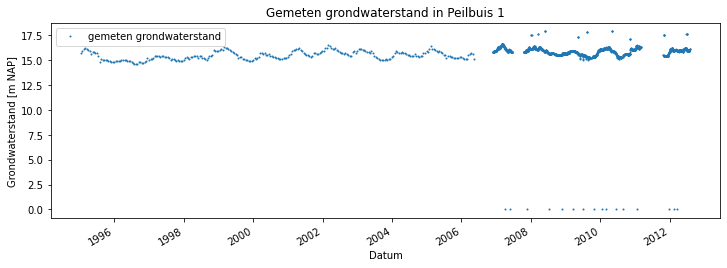

In [2]:
gws = pd.read_csv("data/head_wellex_edit.csv",
                   index_col="Date", parse_dates=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws[:'2012-08-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping ter plaatse van Peilbuis 1. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. 

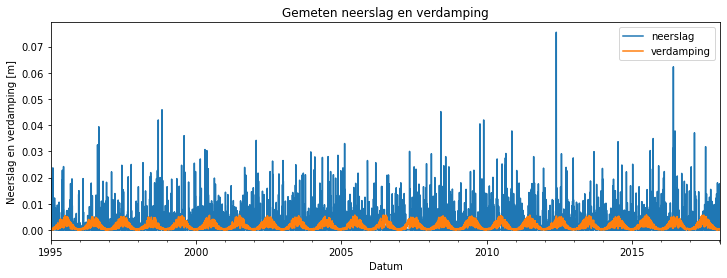

In [3]:
neerslag =  pd.read_csv("data/prec_wellex.csv",
                    index_col="Date", parse_dates=True)
verdamping =  pd.read_csv("data/evap_wellex.csv",
                    index_col="Date", parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);
ax.set_xlim(xmin='1995');

Naast de neerslag en verdamping is ook de data van de onttrekking gebruikt als verklarende reeks voor het tijdreeksmodel. Hiervoor is bij de beheerder van de onttrekking het dagelijkse debiet opgevraagd. Deze is te zien in de afbeelding hieronder.

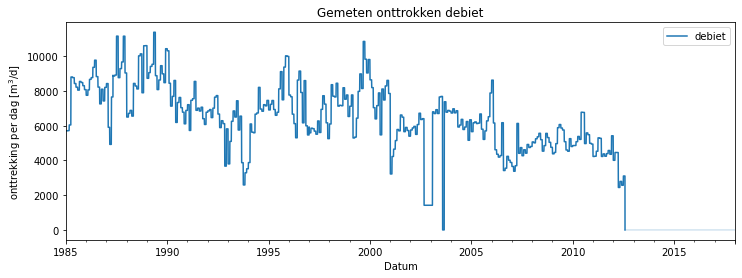

In [4]:
onttrekking =  pd.read_csv("data/well_wellex.csv",
                    index_col="Date", parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
onttrekking[:'2012-08-01'].plot(ax=ax, color='C0')
onttrekking['2012-08-01':].plot(ax=ax, color='C0', alpha=0.2)

# opmaken van de figuur
ax.set_ylabel('onttrekking per dag [m$^3$/d]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten onttrokken debiet')
ax.legend([f'debiet']);


### Voorbewerken reeksen voorbeeld 1
Zoals te zien in de grondwater meetreeks ([Afbeelding: gemeten grondwaterstand](#gws)) bevat de meetreeks een aantal 0 waardes. Deze waardes zijn mogelijk het gevolg van een meetfout van de sensor of het inlezen van de sensor data. Om de reeks bruikbaar te maken voor tijdreeksanalyse moet de meetreeks worden voorberwerkt.

De metingen met een waarde van 0 worden verwijdert uit de reeks om deze te gebruiken in het tijdreeksmodel.


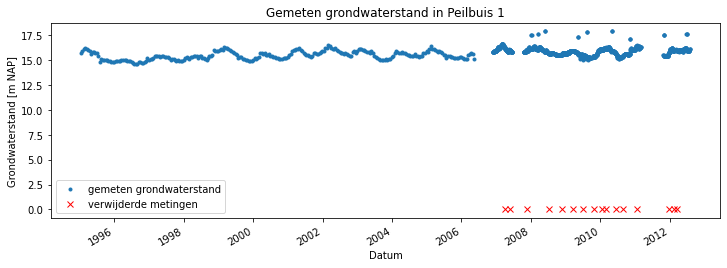

In [5]:
# verwijderde waarden opslaan
gws_del = gws[gws == 0]

# metingen met waarde 0 uit reeks halen
gws_n = gws[gws != 0]

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws_n[:'2012-08-01'].plot(ax=ax, color='C0', ls='', marker='.')
gws_del[:'2012-08-01'].plot(ax=ax, color='red', ls='', marker='x', label='verwijderde waardes')

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend(['gemeten grondwaterstand', 'verwijderde metingen']);

### Opstellen van het tijdreeksmodel

De eerste stap voor het opstellen van het model is het toevoegen van de grondwater observaties aan het model. Voor een eerste berekening wordt de grondwater reeks gebruikt tot aan de huidige datum (niet de "toekomstige" grondwaterstand). In de reeks zijn geen uitschieters gevonden, er is daarom geen reden om de meetreeks voor te bewerken.

De neerslag en verdamping worden toegevoegd aan het model als verklarende reeksen. Om de verklaarende reeksen toe te voegen moet een `respons functie` worden toegekent aan de verklarende reeks (in dit geval regen en verdamping). De respons functie beschrijft de reactie van de grondwaterstand op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type respons functie kiest en waarbij het tijdreeksmodel de parameters van deze functie optimaliseerd. Voor het tijdreeksmodel wordt gebruikt gemaakt van de Gamma respons functie voor de neerslag en verdamping. 

In het tijdreeksmodel wordt dezelfde response functie gebruikt voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule:

$ R = P - f * E$

waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd naast de parameters voor de Gamma respons functie.

Daarnaast wordt de onttrekking als verklarende reeks toegevoegd aan het tijdreekmodel. Voor deze verklarende reeks wordt de Gamma functie gebruikt als respons. De onttrekking wordt geschaald naar Mm$^3$/d, dit is om te voorkomen dat de parameters van deze respons functie sterk afwijken van de overige modelparameters (factor 1.000 tot 10.000), waardoor de optimalisatie slechter wordt. Naast de verklarende reeksen wordt ook de constante (in het tijdreeksmodel $d$) meegefit in het model.

Na het toevoegen van de observaties en de verklarende reeksen kan het tijdreeksmodel worden geoptimaliseerd. De resultaten van het tijdreeksmodel zijn te zien in de onderstaande tabel.


In [6]:
# opzetten model
ml = ps.Model(gws_n[:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking / 1e6,
                    rfunc=ps.Gamma,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml.solve()

# simuleren van de grondwaterstand
gws_simulatie1 = ml.simulate()

Model Results  Head                            Fit Statistics
nfev     23                     EVP                     66.73
nobs     1903                   R2                       0.67
noise    True                   RMSE                     0.24
tmin     1995-01-14 00:00:00    AIC                      8.65
tmax     2012-08-01 00:00:00    BIC                     58.61
freq     D                      Obj                     29.99
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (9 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  733.407042   ±5.80%  203.104730  True
grondwateraanvulling_n    1.233475   ±4.66%    1.000000  True
grondwateraanvulling_a  148.253213  ±11.58%   10.000000  True
grondwateraanvulling_f   -0.826449   ±7.55%   -1.000000  True
onttrekking_A          -194.105106   ±5.01% -338.167845  True
onttrekking_n             0.906891  ±18

In de tabel zijn de verschillende statistieken van het tijdreeksmodel te zien zoals de verklaarde variantie, R$^2$ en root mean square error (RMSE). Er worden basis gegevens voor de reeks en het model weergeven zoals het aantal observaties en de start en eind tijd voor de reeks. Voor de verklarende reeks (`grondwateraanvulling` in dit geval) zijn de geoptimaliseerde parameters te zien, met de standaard afwijkingen van de parameters. Naast de parameters van de respons functie is ook de gefitte constante (`constant_d`) te zien. 

Nu het tijdreeksmodel is geoptimaliseerd kan de gesimuleerde reeks worden geplot. Dit is te zien in de onderstaande afbeelding samen met een overzicht van de model resultaten.

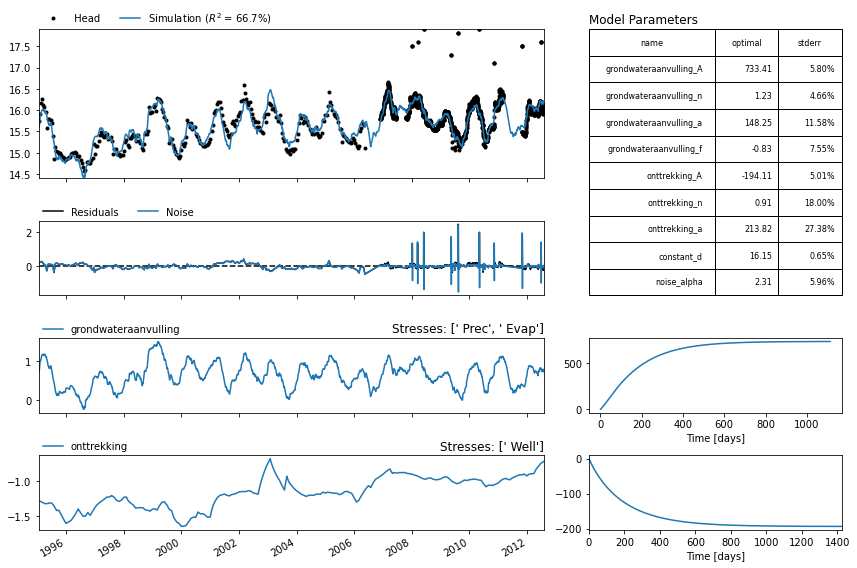

In [7]:
ml.plots.results(figsize=(12,8));

Bij de resultaten van het model valt op dat het tijdreeksmodel niet in staat is om de uitschieters in de meetreeks correct te simuleren. Na overleg met de beheerder van het gebied waar Peilbuis 1 in staat blijkt dat de metingen van boven de +17 m NAP onrealistisch zijn, deze metingen komen niet overeen met wat er in het veld is geobserveerd. Mogelijk is de peilbuis gedurende deze dagen volgelopen waardoor hogere waardes zijn geregisteerd. 

Deze uitschieters kunnen het tijdreeksmodel mogelijk negatief beinvloeden omdat deze metingen niet verklaard kunnen worden met behulp van de verklarende reeksen die worden gebruikt. Daarom wordt het tijdreeksmodel opnieuw gemaakt maar worden nu enkel grondwatermetingen meegenomen van < +17 m NAP. 

In de onderstaande tabel zijn de resultaten van het tijdreeksmodel weergeven.

In [8]:
# opzetten model met enkel metingen van < 17 m NAP
ml2 = ps.Model(gws_n[gws_n < 17.0][:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml2.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking / 1e6 ,
                    rfunc=ps.Gamma,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml2.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml2.solve()

# simuleren van de grondwaterstand
gws_simulatie2 = ml2.simulate()


Model Results  Head                            Fit Statistics
nfev     28                     EVP                     89.97
nobs     1875                   R2                       0.90
noise    True                   RMSE                     0.11
tmin     1995-01-14 00:00:00    AIC                     11.59
tmax     2012-08-01 00:00:00    BIC                     61.42
freq     D                      Obj                      1.28
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (9 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  754.194830   ±7.24%  203.104730  True
grondwateraanvulling_n    1.334268   ±2.44%    1.000000  True
grondwateraanvulling_a  104.457110   ±9.01%   10.000000  True
grondwateraanvulling_f   -0.593365   ±9.85%   -1.000000  True
onttrekking_A          -165.253611  ±10.06% -338.167845  True
onttrekking_n             1.356392  ±25

De resultaten van het tijdreeksmodel zijn te zien in de onderstaande afbeelding. Hierbij zijn is de gesimuleerd grondwaterstand weergeven met de geobserveerde grondwaterstand. De `residuals` en `noise` van het model zijn weergeven.

Voor de verschillende verklarende reeksen zijn de bijdrages aan de grondwaterstand te zien. Daarnaast zijn voor de verklarende reeksen de step response functies weergeven. 


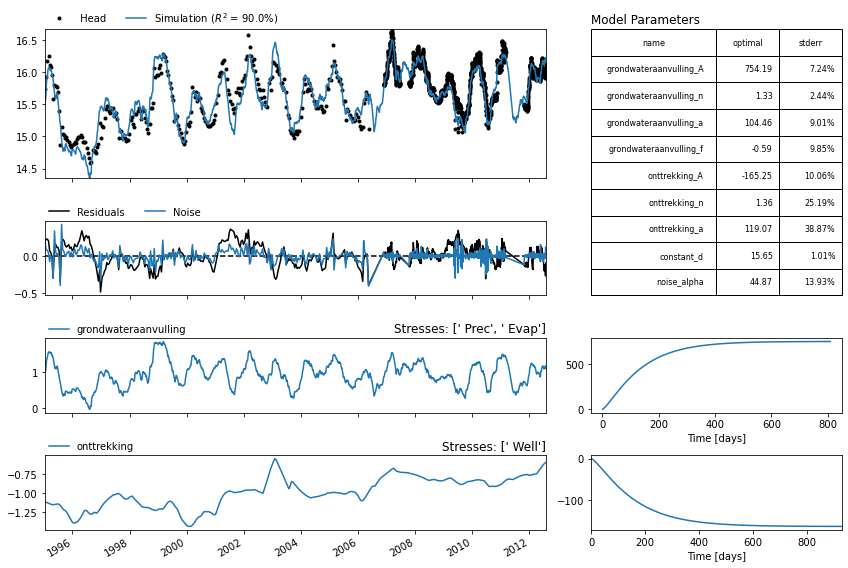

In [9]:
ml2.plots.results(figsize=(12,8));

Het 2de tijdreeksmodel, waarbij de metingen van > 17 m NAP niet zijn meegenomen, heeft hogere verklaarde variantie en R$^2$, en een lagere root mean square error (RMSE). In de onderstaande afbeelding is de gesimuleerde grondwaterreeks van het nieuwe tijdreeksmodel vergeleken met het 1ste tijdreeksmodel. Hierbij is te zien dat op basis van een visuele inspectie het lastig te zien is welk tijdreeksmodel beter presteerd.

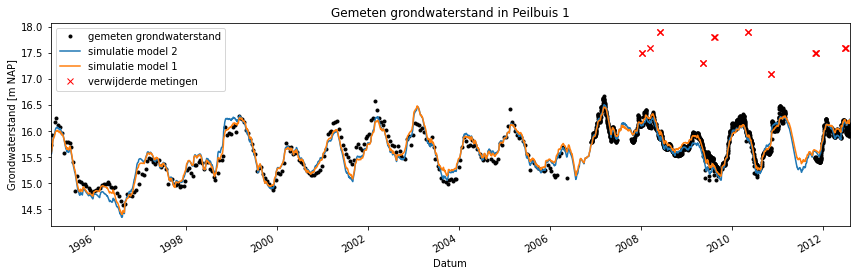

In [10]:
fig, ax = plt.subplots(1,1, figsize=(12,4))
ml2.plot(ax=ax);
gws_simulatie1.plot(ax=ax);

#verdijderde metingen aangeven
ax.plot(gws_n[gws_n > 17], marker='x', ls='', color='r')

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend(['gemeten grondwaterstand', 'simulatie model 2',
          'simulatie model 1', 'verwijderde metingen']);

In eerste instantie zijn voor beide verklarende reeksen de Gamma respons functies gebruikt. Het is aan de modelleur om de keuze voor de respons functie te maken. Daarom wordt het model nogmaals opgesteld met verschillende respons functies om deze te vergelijken. Hierbij wordt voor beide verklarende reeksen de volgende respons functies gebruikt: Exponentieel, Gamma en de Hantush respons. 

In de onderstaande tabellen zijn de R$^2$, EVP en RMSE van de modellen weergeven. Langs de rijen van de tabellen staat de respons functie van de neerslag en verdamping en langs de kolommen de respons functie van de onttrekking.

In [11]:
R2_df = pd.DataFrame()
RMSE_df = pd.DataFrame()
EVP_df = pd.DataFrame()

for res_precevap in [ps.Exponential, ps.Gamma, ps.Hantush]:
    for res_onttreking in [ps.Exponential, ps.Gamma, ps.Hantush]:
        ml2 = ps.Model(gws_n[gws_n < 17.0][:'2012-08-01'])

        # toevoegen van neerslag en verdamping als verklarende reeksen
        sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                            rfunc=res_precevap,
                            name='grondwateraanvulling',
                            settings=('prec', 'evap'))
        ml2.add_stressmodel(sm1)

        # toevoegen van onttrekking als verklarende reeks
        sm2 = ps.StressModel(stress=onttrekking / 1e6,
                            rfunc=res_onttreking,
                            name='onttrekking',
                            settings='well',
                            up=False)
        ml2.add_stressmodel(sm2)

        # oplossen van het tijdreeksmodel
        ml2.solve(report=False)
        r = str(res_precevap).split('.')[-1][:-2]
        c = str(res_onttreking).split('.')[-1][:-2]
        R2_df.loc[r, c] = ml2.stats.rsq()
        RMSE_df.loc[r, c] = ml2.stats.rmse()
        EVP_df.loc[r, c] = ml2.stats.evp()

print('Model R\u00b2')
display(R2_df)
print('Model EVP')
display(EVP_df)
print('Model RMSE')
display(RMSE_df)


Model R²


,Exponential,Gamma,Hantush
Exponential,0.830712,0.830324,0.828239
Gamma,0.897199,0.895327,0.894556
Hantush,0.610652,0.610876,0.603275


Model EVP


,Exponential,Gamma,Hantush
Exponential,83.492714,83.474456,83.150936
Gamma,90.088498,89.973560,89.909439
Hantush,61.321130,61.856849,60.748273


Model RMSE


,Exponential,Gamma,Hantush
Exponential,0.145733,0.145899,0.146793
Gamma,0.113564,0.114594,0.115015
Hantush,0.221010,0.220947,0.223094


Zoals te zien in de tabellen zijn er verschillende combinaties voor de respons functies die gelijkwaardige model prestaties geven. Voor de neerslag en verdamping geeft de Gamma respons functie de beste resultaten. 

Voor de onttrekking wordt voor alle respons functies een vergelijkbaar model resultaat gevonden. Daarom wordt voor deze verklarende reeks gekozen voor de Exponentiele respons functie. Deze heeft de minste modelparameters om te optimaliseren en heeft daarom de voorkeur boven de andere respons functies. 

In [12]:
ml2 = ps.Model(gws_n[gws_n < 17.0][:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml2.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking / 1e6,
                    rfunc=ps.Exponential,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml2.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml2.solve(report=True)

ml2_sim = ml2.simulate(tmax='2018-01-12')

Model Results  Head                            Fit Statistics
nfev     29                     EVP                     90.09
nobs     1875                   R2                       0.90
noise    True                   RMSE                     0.11
tmin     1995-01-14 00:00:00    AIC                      9.63
tmax     2012-08-01 00:00:00    BIC                     53.92
freq     D                      Obj                      1.28
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (8 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  756.104675   ±7.32%  203.104730  True
grondwateraanvulling_n    1.333706   ±2.46%    1.000000  True
grondwateraanvulling_a  105.382080   ±9.07%   10.000000  True
grondwateraanvulling_f   -0.593264   ±9.94%   -1.000000  True
onttrekking_A          -169.443765  ±10.35% -338.167845  True
onttrekking_a           184.052010  ±22

### Voorspellen van de grondwaterstand

Nu het tijdreeksmodel is opgesteld en de parameters van de verschillende respons functies zijn geoptimaliseerd kan het model gebruikt worden om het effect van het afbouwen van de onttrekking te voorspellen. 

Hiervoor wordt gekeken naar de respons functie van de onttrekking. Deze is te zien in de onderstaande afbeelding. Hierbij is ook de bandbreedte van de respons functie te zien met een 95% zekerheidsinterval. Deze is bepaald met behulp van een Monte Carlo Sampling op basis van de resultaten van de tijdreeksanalyse. Te zien is dat de respons functie na ca. 1250 dagen (~3.5 jaar) stabiliseerd. De "gain" (niveau waarop de respons functie stabiliseert) van de respons functie is gelijk aan -169 m, de verlaging die optreedt ten gevolge van permanente een onttrekking van Mm$^3$/d. De bandbreedte loop hierbij van -136 tot -205.

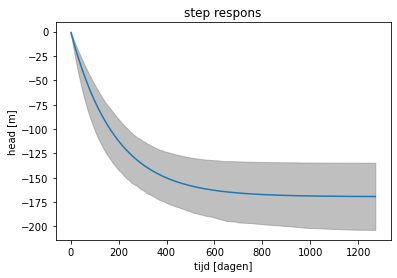

In [13]:
fig, ax = plt.subplots()
step = ml2.get_step_response('onttrekking')
ci_step = ml2.fit.ci_step_response('onttrekking')
ax.plot(step)
ax.fill_between(x = ci_step.index, y1=ci_step[0.025], y2=ci_step[0.975], color='gray', alpha=0.5)

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('step respons');

Met behulp van deze respons functie kan de verwachte stijging van de grondwaterstand ten gevolge van het uitzetten van de ontrekking worden voorspeld. De gemiddelde onttrekking bedraagt 5427 m$^3$/d. De respons ten gevolge van de verandering van gemiddeld 5427 naar 0 m$^3$/d is te zien in de onderstaande afbeelding, hierbij is de respons zoals hierboven gezien geschaald naar de gemiddelde onttrekking. De gemiddelde verwachte stijging is tussen de 0.74 en 1.11 meter, waarbij het effect van de onttrekking na 1250 dagen is uitgedempt.

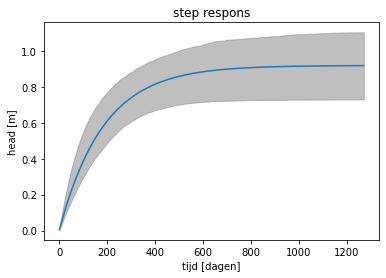

In [14]:
fig, ax = plt.subplots()

ax.plot(step * -5427 / 1e6)
ax.fill_between(x = ci_step.index, y1=ci_step[0.025] * -5427 / 1e6,
                y2=ci_step[0.975] * -5427 / 1e6, color='gray', alpha=0.5)
verwachting = step.iloc[-1] * -5427 / 1e6
bovengrens = ci_step[0.025].iloc[-1] * -5427 / 1e6
ondergrens = ci_step[0.975].iloc[-1] * -5427 / 1e6

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('step respons');

Een aantal jaar later besluit het waterschap te kijken of de voorspelling van de voorspelling van het adviesbureau voor de stijging van de grondwaterstand is uitgekomen. Hierbij worden de meeste recente metingen van de grondwaterstand gebruikt. De volledige reeks is te zien in de onderstaande afbeelding. Hierin is te zien dat de grondwaterstand sinds 2012 lijkt te zijn toegenomen. 

In de afbeelding is daarnaast de simulatie te zien waarbij de meeste recente data is gebruikt voor de neerslag en verdamping. 

Hierbij is te zien dat het model een overschatting maakt van het effect van het uitzetten van de onttrekking. De gesimuleerde grondwaterstand loopt op tot boven de gemeten grondwaterstand. 


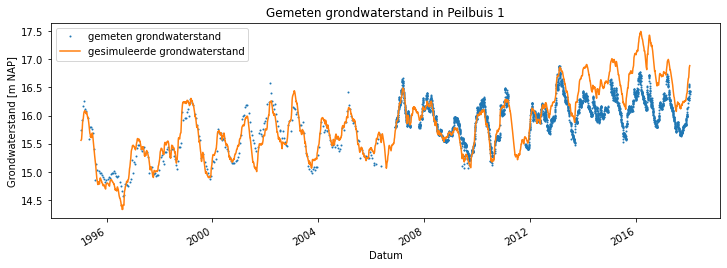

In [15]:
# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws_n[gws_n < 17.0].plot(ax=ax, color='C0', ls='', marker='.', markersize=2)
ml2_sim.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand', 'gesimuleerde grondwaterstand']);

Er wordt een nieuw tijdreeksmodel opgesteld met de meest recente data. Hierbij wordt dezelfde opzet gehanteerd als bij het vorige tijdreeksmodel met dezelfde respons functies. De meetreeksen voor de neerslag en verdamping en de onttrekking zijn aangevuld met de meest recente data. De resultaten van het nieuwe tijdreeksmodel zijn te zien in de onderstaande tabel.

In [16]:
ml2 = ps.Model(gws_n[gws_n < 17.0])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml2.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=onttrekking / 1e6,
                    rfunc=ps.Exponential,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml2.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml2.solve(report=True)

Model Results  Head                            Fit Statistics
nfev     41                     EVP                     75.12
nobs     3759                   R2                       0.75
noise    True                   RMSE                     0.18
tmin     1995-01-14 00:00:00    AIC                      6.44
tmax     2018-01-12 00:00:00    BIC                     56.29
freq     D                      Obj                      1.63
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (8 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  545.726406   ±9.67%  203.104730  True
grondwateraanvulling_n    1.355868   ±1.53%    1.000000  True
grondwateraanvulling_a   67.726310   ±8.62%   10.000000  True
grondwateraanvulling_f   -0.554898  ±10.42%   -1.000000  True
onttrekking_A           -98.428216  ±12.28% -338.167845  True
onttrekking_a           124.895469  ±38

De simulatie van het tijdreeksmodel met de volledige meetreeks is te zien in de onderstaande afbeelding. Te zien is dat het nieuwe tijdreeksmodel de grondwaterstand vanaf 2012 beter simuleerd. De parameters van de respons functie van de onttrekking wijken af van het oude tijdreeksmodel.

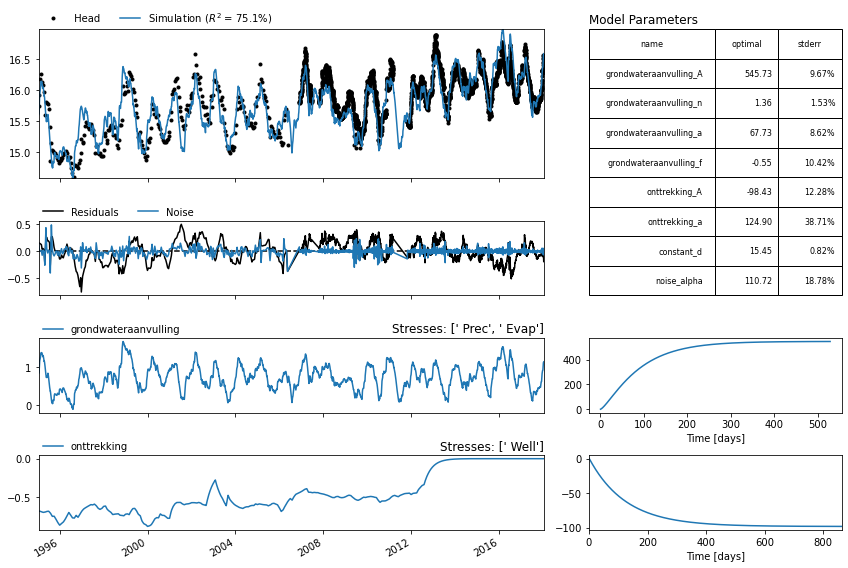

In [17]:
ml2.plots.results(figsize=(12,8));

De step responses van beide modellen zijn weergeven in de onderstaande afbeelding. Hierin is te zien dat de respons functies verschillen. De "gain" (parameter `onttrekking_A`) van de nieuwe respons functie is lager dan die van het oude model, daarnaast is ook de lengte van de respons korter (het effect van de onttrekking dempt sneller uit). 

Met de nieuwe respons functie ligt de bandbreedte van het effect van het uitzetten van de onttrekking tussen de 0.42 en 0.66 meter tegenover de bandbreedte tussen de 0.74 en 1.11 meter van het oude tijdreeksmodel. Daarnaast zal volgens het nieuwe tijdreeksmodel het effect van de onttrekking ook sneller uitdempen ca. 1.5 jaar tegenover ca. 3.5 jaar in het oude model. De voorspelling is een overschatting geweest van de daadwerkelijke stijging. Dit is ook te zien in de simulatie van het ouder tijdreeksmodel waarbij de grondwaterstand vanaf het jaar 2012 wordt overschat door het model (het model overschat de stijging ten gevolge van het uitzetten van de onttrekking). 

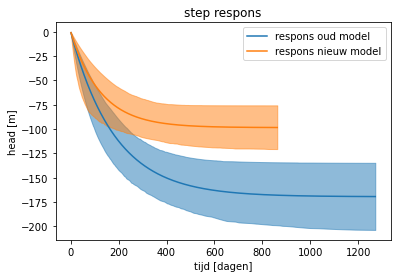

In [18]:
fig, ax = plt.subplots()

step_new = ml2.get_step_response('onttrekking')
ci_step_new = ml2.fit.ci_step_response('onttrekking')

ax.plot(step)
ax.plot(step_new)
ax.fill_between(x = ci_step.index, y1=ci_step[0.025], y2=ci_step[0.975], color='C0', alpha=0.5)
ax.fill_between(x = ci_step_new.index, y1=ci_step_new[0.025], y2=ci_step_new[0.975], color='C1', alpha=0.5)

verwachting_new = step_new.iloc[-1] * -5427 / 1e6
ondergrens_new = ci_step_new[0.025].iloc[-1] * -5427 / 1e6
bovengrens_new = ci_step_new[0.975].iloc[-1] * -5427 / 1e6

# figuur opmaken
ax.set_xlabel('tijd [dagen]')
ax.set_ylabel('head [m]')
ax.set_title('step respons');
ax.legend(['respons oud model', 'respons nieuw model']);

## Deel II: Herstel grondwaterstand in april

In een natuurgebied wordt de grondwaterstand al jaren gemeten in PB01. In de afgelopen jaren (2018 en 2019) merkt het waterschap dat de grondwaterstand in de zomerperiode lager ligt dan gemiddeld. Ook bij de laatste metingen in augustus 2019 was dit het geval. Aan de hydroloog van het waterschap is gevraagd of een inschatting kan worden gegeven voor de grondwaterstand bij de start van het nieuwe groeiseizoen in april volgend jaar (april 2020). 

Op basis van een tijdreeksanalyse wordt gekeken naar de verwachte grondwaterstand ten gevolge van een "natte", "droge" en een "gemiddelde" winterperiode (van september tot april). Zo hoop het waterschap inzicht te krijgen in het herstel van de grondwaterstand.

### Beschikbare gegevens

In de onderstaande afbeelding is de meetreeks van peilbuis PB01 te zien. De meetreeks loopt van 1985 tot september 2019. De variatie in de grondwaterstand is ca. 2 meter. In de reeks is te zien dat de grondwaterstand in de zomer van 2018 en 2019 relatief laag is geweest vanwege de droge zomer periodes.

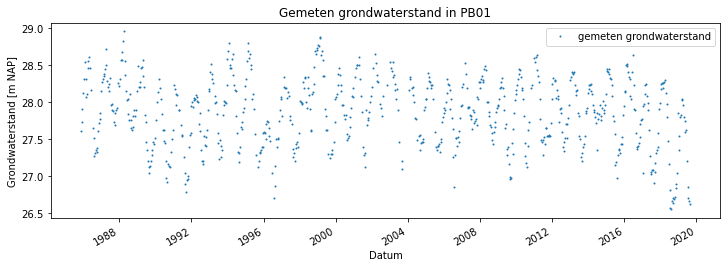

In [19]:
gws = ps.read_dino('data/PB01.csv').series

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
gws[:'2019-09-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in PB01')
ax.legend([f'gemeten grondwaterstand']);

De data voor de neerslag en verdamping nabij PB01 zijn verzameld van het dichtsbijzijnde KNMI weerstation. De neerslag en verdamping zijn weergeven in de onderstaande grafiek. Het weerstation bevat data vanaf 1965 tot en met september 2019. 

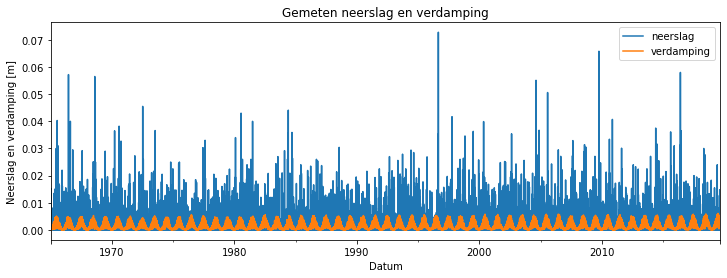

In [20]:
neerslag = pd.read_csv('data/neerslag.csv', index_col=0, parse_dates=True)
verdamping = pd.read_csv('data/verdamping.csv', index_col=0, parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag[:'2019-09-01'].plot(ax=ax, color='C0')
verdamping[:'2019-09-01'].plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);


### Opzetten tijdreeksmodel

Er wordt een tijdreeksmodel opgesteld op basis van de meetreeks in PB01. Hiervoor worden de neerslag en verdamping gebruikt als verklarende reeks. Voor de neerslag en verdamping wordt de Exponentiele respons functie gebruikt in de tijdreeksanalyse.

De resultaten van het tijdreeksmodel zijn weergeven in de onderstaande tabel. 

In [21]:
# opzetten model
ml = ps.Model(gws[:'2019-09-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Exponential,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve()

Model Results PB01_1                           Fit Statistics
nfev     13                     EVP                     92.46
nobs     744                    R2                       0.92
noise    True                   RMSE                     0.13
tmin     1985-11-14 00:00:00    AIC                      5.06
tmax     2019-08-28 00:00:00    BIC                     28.12
freq     D                      Obj                      3.20
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           ___                          

Parameters (5 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  685.480945   ±4.91%  219.794219  True
grondwateraanvulling_a  157.529902   ±4.68%   10.000000  True
grondwateraanvulling_f   -1.311138   ±4.14%   -1.000000  True
constant_d               27.920415   ±0.21%   27.859651  True
noise_alpha              40.630027  ±10.35%   15.000000  True

Parameter correlations |rho| > 0.5
gro

Het tijdreeksmodel heeft een EVP van 92% en een R$^2$ van 0.92. In de onderstaande figuur is de simulatie van het tijdreeksmodel te zien. De variatie in grondwaterstand lijkt goed verklaard te kunnen worden met behulp van de neerslag en verdamping. Het tijdreesmodel is gesimuleerd tot aan 1 september 2019.

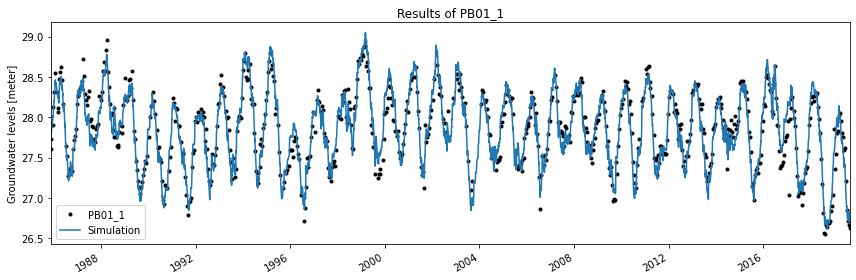

In [22]:
ml.plot(figsize=(12,4));

### Voorspelling neerslagoverschot
Om een inschatting te maken van de grondwaterstand ten gevolge van de "natte", "droge" en "gemiddelde" winterperiode wordt gekeken naar het neerslagoverschot van de afgelopen 30 jaar. 

Het neerslagoverschot wordt berekend als: 
$$P - f_{verdamping} * E$$
waarbij $P$ de neerslag is, $E$ de potentiele verdamping en $f_{verdamping}$ de verdampingsfactor zoals bepaald met de tijdreeksanalyse. In de onderstaande afbeeldingen zijn de neerslagoverschotten van de afgelopen 30 jaar weergeven, waarbij de jaren 2018 en 2019 zijn gemarkeerd.

Hierin valt op dat, voor de periode september - april, het neerslagoverschot in 2018 tot een van de laagste van de afgelopen 30 jaar behoort wat overeenkomt met de ervaring van de droge periode in 2018.

Voor het "natte" jaar wordt de 90% bovengrens van het neerslag overschot aangehouden. Voor het droge jaar de 5% ondergrens. Het "gemiddelde" jaar wordt op basis van het gemiddelde neerslagoverschot berekend. Deze scenario's zijn berekend op basis van de dagelijkse neerslagoverschotten, per dag is de 95%, 5% of gemiddelde waarde voor het neerslagoverschot bepaald. 

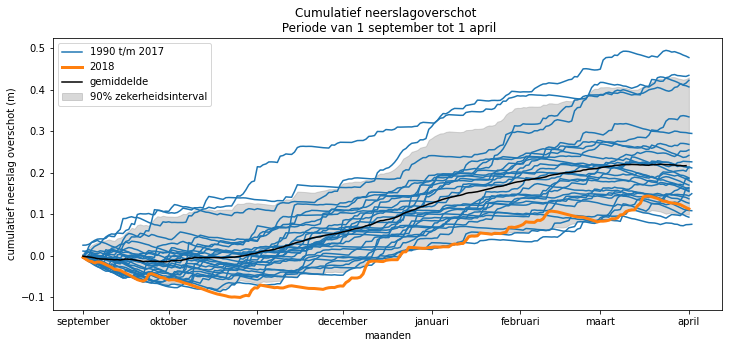

In [23]:
plt.figure(figsize=(12,5))

overschot = pd.DataFrame()
fac_verdamping = ml.parameters.loc['grondwateraanvulling_f', 'optimal']
for year in range(1990, 2019, 1):
    y = (neerslag[f'{year}-09-01':f'{year+1}-04-01'] + fac_verdamping * verdamping[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))
    
    if year == 1990:
        plt.plot(x,y, color='C0', label='1990 t/m 2017')
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    elif year == 2018:
        plt.plot(x,y, color='C1', label='2018', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    else:
        plt.plot(x,y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    overschot = pd.concat([overschot, y], axis=1)

bovengrens = overschot.quantile(0.95, axis=1)
ondergrens = overschot.quantile(0.05, axis=1)
gemiddelde = overschot.mean(axis=1)
overschot = overschot.drop(index='2-29')
bovengrens = bovengrens.drop(index='2-29')
ondergrens = ondergrens.drop(index='2-29')
gemiddelde = gemiddelde.drop(index='2-29')

plt.fill_between(x=x, y1=ondergrens.values, y2=bovengrens.values, color='gray', alpha=0.3, label='90% zekerheidsinterval')
plt.plot(x[:-1], gemiddelde[:-1], color='k', label='gemiddelde')
plt.xlabel('maanden')
plt.ylabel('cumulatief neerslag overschot (m)')
plt.legend()
plt.title('Cumulatief neerslagoverschot \n Periode van 1 september tot 1 april')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]), 
           labels=['september','oktober', 'november', 'december', 'januari',
                                        'februari','maart','april']);


### Voorspellen grondwaterstand
Voor de 3 scenario's wordt met behulp van de resultaten van het tijdreeksmodel de grondwaterstand bepaald voor 1 april 2020. Hierbij wordt er vanuit gegaan dat het systeem niet verandert en dat er geen extra invloeden op de grondwaterstand bijkomen in de periode van simuleren.

Met behulp van convolutie en de respons functie bepaald door het tijdreeksmodel wordt het verloop van de grondwaterstand voor de periode 1 september 2019 tot 1 april 2020 berekend. In de onderstaande afbeelding zijn voor de 3 scenario's de voorspellingen van de grondwaterstand te zien. Deze geven een bandbreedte van de grondwaterstand voor de periode tot 1 april 2020. Met de voorspelling kan worden gekeken of de grondwaterstand bij een "droog", "nat" of "gemiddeld" winterseizoen hersteld van een droge periode. 

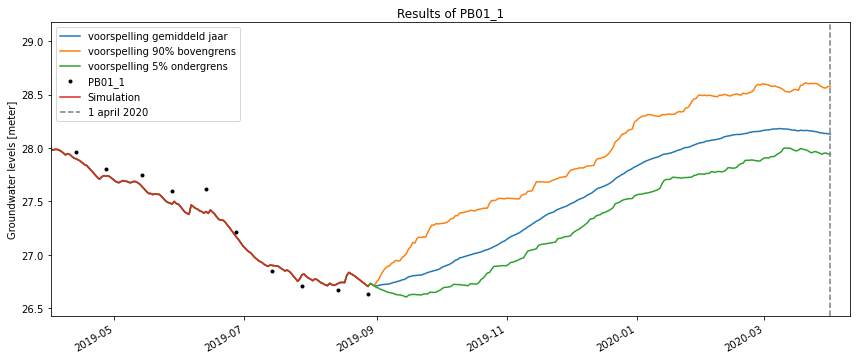

In [24]:
# opzetten model
ml_sim = ml.copy()

fig, ax = plt.subplots(figsize=(12,5))

gemiddelde.index = pd.date_range('2019-09-01', '2020-03-31')
gemiddelde_stress = neerslag[:'2019-08-31'] + fac_verdamping * verdamping[:'2019-08-31']
gemiddelde_stress = gemiddelde_stress['head'].append(gemiddelde.diff().fillna(gemiddelde))

ml_sim.del_stressmodel('grondwateraanvulling')
sm_sim = ps.StressModel(stress=gemiddelde_stress,
                    rfunc=ps.Exponential,
                    name='grondwateraanvulling',
                    settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['grondwateraanvulling_a', 'optimal'] = ml.parameters.loc['grondwateraanvulling_a', 'optimal']
ml_sim.parameters.loc['grondwateraanvulling_A', 'optimal'] = ml.parameters.loc['grondwateraanvulling_A', 'optimal']

gemiddelde_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(gemiddelde_sim, label='voorspelling gemiddeld jaar')

bovengrens.index = pd.date_range('2019-09-01', '2020-03-31')
bovengrens_stress = neerslag[:'2019-08-31'] + fac_verdamping * verdamping[:'2019-08-31']
bovengrens_stress = bovengrens_stress['head'].append(bovengrens.diff().fillna(bovengrens))

ml_sim.del_stressmodel('grondwateraanvulling')
sm_sim = ps.StressModel(stress=bovengrens_stress,
                    rfunc=ps.Exponential,
                    name='grondwateraanvulling',
                    settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['grondwateraanvulling_a', 'optimal'] = ml.parameters.loc['grondwateraanvulling_a', 'optimal']
ml_sim.parameters.loc['grondwateraanvulling_A', 'optimal'] = ml.parameters.loc['grondwateraanvulling_A', 'optimal']

bovengrens_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(bovengrens_sim, label='voorspelling 90% bovengrens')

ondergrens.index = pd.date_range('2019-09-01', '2020-03-31')
ondergrens_stress = neerslag[:'2019-08-31'] + fac_verdamping * verdamping[:'2019-08-31']
ondergrens_stress = ondergrens_stress['head'].append(ondergrens.diff().fillna(ondergrens))

ml_sim.del_stressmodel('grondwateraanvulling')
sm_sim = ps.StressModel(stress=ondergrens_stress,
                    rfunc=ps.Exponential,
                    name='grondwateraanvulling',
                    settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['grondwateraanvulling_a', 'optimal'] = ml.parameters.loc['grondwateraanvulling_a', 'optimal']
ml_sim.parameters.loc['grondwateraanvulling_A', 'optimal'] = ml.parameters.loc['grondwateraanvulling_A', 'optimal']

ondergrens_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(ondergrens_sim, label='voorspelling 5% ondergrens')

ml.plot(ax=ax)
ax.axvline('2020-04-01', color='gray', ls='--', label='1 april 2020')
ax.legend()
ax.set_xlim(xmin='2019-04-01', xmax='2020-04-10');


Na april wordt door het waterschap de meest recente data van peilbuis PB01 verzameld. Deze kunnen worden vergeleken met de voorspelling gemaakt in september. In de onderstaande afbeelding zijn de daadwerkelijk gemeten grondwaterstanden weergeven met de voorspellingen.

Te zien is dat daadwerkelijk gemeten grondwaterstand in de periode september-oktober lager ligt dan het gemiddelde scenario. In de periode vanaf maart 2020 is de gemeten grondwaterstand hoger dat het gemiddelde scenario.

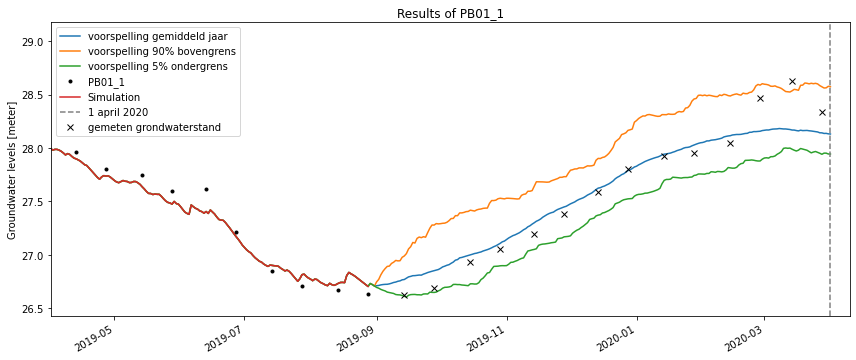

In [25]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(gemiddelde_sim, label='voorspelling gemiddeld jaar')
ax.plot(bovengrens_sim, label='voorspelling 90% bovengrens')
ax.plot(ondergrens_sim, label='voorspelling 5% ondergrens')
ml.plot(ax=ax)
ax.axvline('2020-04-01', color='gray', ls='--', label='1 april 2020')
ax.plot(gws['2019-09-01':'2020-04-10'], marker='x', ls='', color='k', label='gemeten grondwaterstand')
ax.legend()
ax.set_xlim(xmin='2019-04-01', xmax='2020-04-10');


In de onderstaande figuur is voor de periode september 2019 - april 2020 het neerslagoverschot vergeleken met de neerslagoverschotten van de overige jaren. Hierbij is te zien dat voor dit jaar in september-oktober het overschot lager is dan gemiddeld en in de period maart-april hoger. Dit komt overeen met de vergelijking tussen het gemiddelde scenario en de metingen.

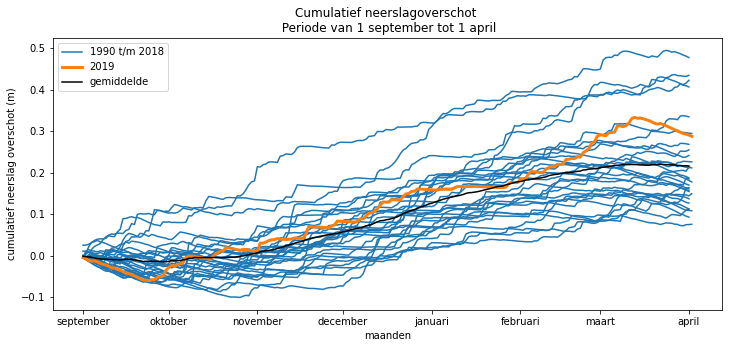

In [26]:
plt.figure(figsize=(12,5))

fac_verdamping = ml.parameters.loc['grondwateraanvulling_f', 'optimal']
for year in range(1990, 2020, 1):
    y = (neerslag[f'{year}-09-01':f'{year+1}-04-01'] + fac_verdamping * verdamping[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))
    
    if year == 1990:
        plt.plot(x,y, color='C0', label='1990 t/m 2018')
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    elif year == 2019:
        plt.plot(x,y, color='C1', label='2019', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    else:
        plt.plot(x,y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year,9,1)
    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    overschot = pd.concat([overschot, y], axis=1)

# plt.fill_between(x=x, y1=ondergrens.values, y2=bovengrens.values, color='gray', alpha=0.3, label='90% zekerheidsinterval')
plt.plot(x[:-1], gemiddelde, color='k', label='gemiddelde')
plt.xlabel('maanden')
plt.ylabel('cumulatief neerslag overschot (m)')
plt.legend()
plt.title('Cumulatief neerslagoverschot \n Periode van 1 september tot 1 april')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]), 
           labels=['september','oktober', 'november', 'december', 'januari',
                                        'februari','maart','april']);


In [27]:
etmgeg_380 = ps.read_knmi('data\etmgeg_380.txt', variables='EV24').series
etmgeg_380.name = 'head'
etmgeg_380.index.name='date'

etmgeg_380['1965':].to_csv(r'data\verdamping.csv')

heibloem = ps.read_knmi(r'data\neerslaggeg_HEIBLOEM_967.txt', variables ='RD').series
heibloem.name = 'head'
heibloem.index.name='date'

heibloem['1965':].to_csv(r'data\neerslag.csv');

FileNotFoundError: [Errno 2] No such file or directory: 'data\\etmgeg_380.txt'